# Square roots & Poisson noise

Quick notebook to demonstrate the usefulness - and limitations - of applying a square root transform to pixels in a fluorescence microsopy image (sometimes).

## Create a simulated image

Read a suitable simulated image, where the pixel values correspond to the 'true signal' in terms of photon counts.

In practice, the 'true signal' here is what you'd get if you averaged lots of individual noisy images together, so we're allowed fractional parts.

In [1]:
from imageio import imread
from matplotlib import pyplot as plt
import numpy as np
from typing import Tuple

In [2]:
im = imread('happy_cell.png').astype(np.float64)
if im.ndim > 2:
    im = im[:, :, 0]

# Normalize between 0 and 1
im = im - im.min()
im /= im.max()

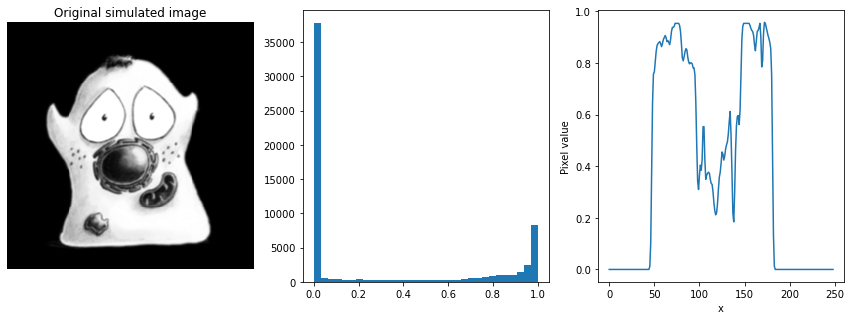

In [3]:
def show_image(im: np.ndarray, title: str = None, percent=0.1, bins=32):
    """
    Show image, histogram & profile plot in a standardized way.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    
    row = im.shape[0]//2
    
    im_args = dict(cmap='gray', interpolation='none')
    if percent <= 0:
        plt.imshow(im, vmin=im.min(), vmax=im.max(), **im_args)
    else:
        plt.imshow(im, vmin=np.percentile(im.flatten(), percent), vmax=np.percentile(im.flatten(), 100-percent), **im_args)
    plt.axis(False)
    if title:
        plt.title(title)
        
    if bins is not None:
        plt.subplot(1, 3, 2)
        pixels = im.flatten()
        plt.hist(pixels, bins=bins)
        
    plt.subplot(1, 3, 3)
    plt.plot(im[row, :])
    plt.xlabel('x')
    plt.ylabel('Pixel value')
    
    plt.show()

show_image(im, title='Original simulated image')

## Simulate photon counts

Convert our idealized image into something with simulated photon counts, then plot the result.

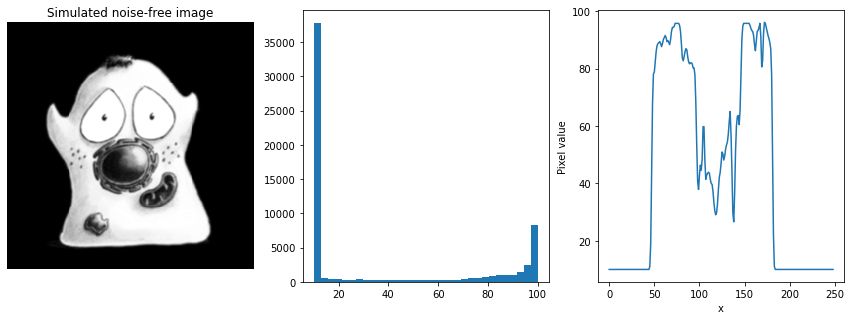

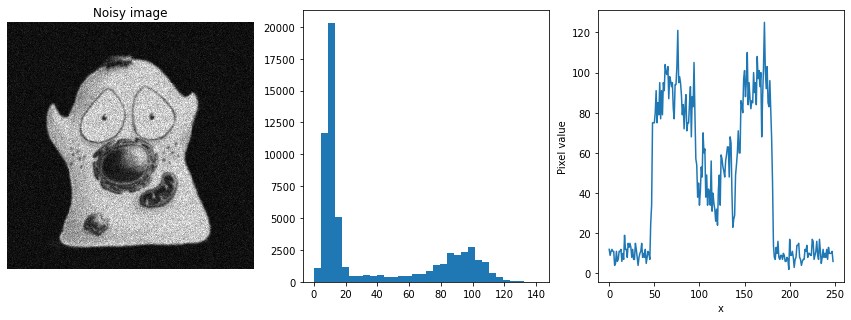

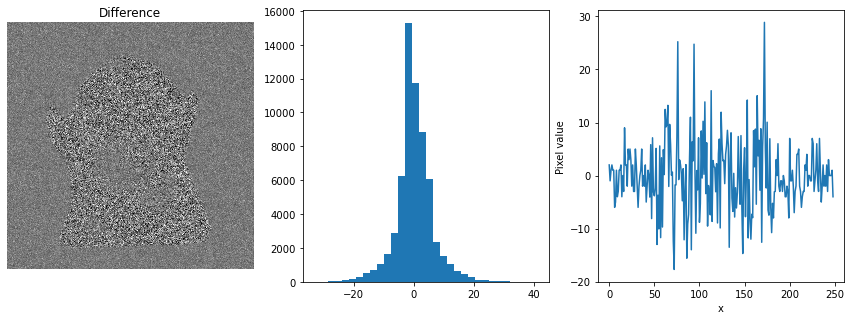

In [4]:
def simulate_counts(im: np.ndarray, baseline:float=0, max_photons:float=1, rng_seed=100) -> Tuple[np.ndarray, np.ndarray]:
    im_clean = im * max_photons + baseline
    rng = np.random.RandomState(rng_seed)
    im_noisy = rng.poisson(im_clean)
    return im_noisy, im_clean

# Baseline defines the 'true' value even where the image is dark
baseline = 10
# Max photons describes the increase over the baseline seen where the image is brightest
max_photons = 90

im_noisy, im_clean = simulate_counts(im, baseline=baseline, max_photons=max_photons)

show_image(im_clean, title='Simulated noise-free image')
show_image(im_noisy, title='Noisy image')
show_image(im_noisy - im_clean, title='Difference')

The main thing to notice is that the image looks 'noisier' where the cell is brighter.

When we subtract the noise-free simulation from the noisy image, the distribution is a bit peaked in the middle and the noise varies depending upon where in the image we look.

## Apply square root transform

Now we apply the square root transform to stabilize the Poisson noise, in the hope this helps.
See https://en.wikipedia.org/wiki/Anscombe_transform for more details.

> We don't bother with the 3/8, because in practice we're likely to have offsets & gain thwarting our pixels-are-photon-counts expectation.

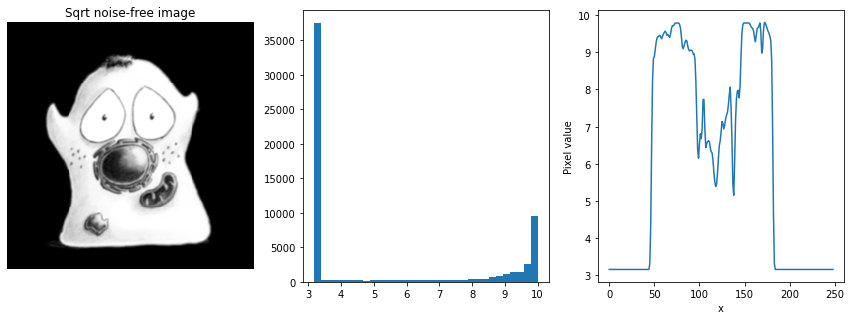

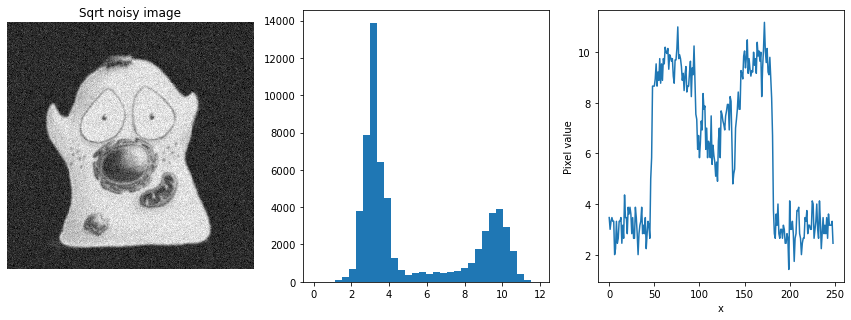

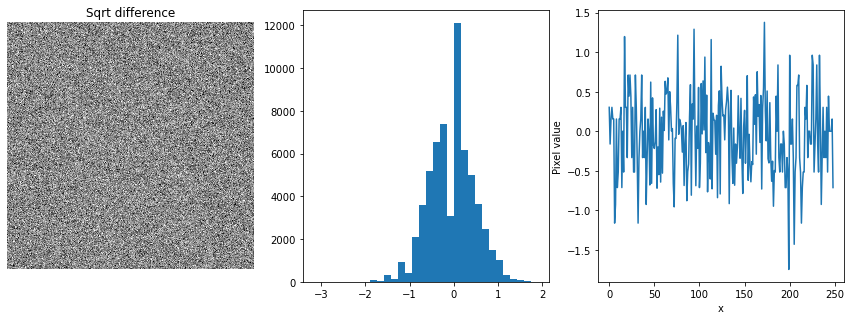

In [5]:
show_image(np.sqrt(im_clean), title='Sqrt noise-free image')
show_image(np.sqrt(im_noisy), title='Sqrt noisy image')
show_image(np.sqrt(im_noisy) - np.sqrt(im_clean), title='Sqrt difference')

**Success!**

Taking the square root of all pixels has effectively made the noise standard deviation much the same everywhere, regardless of the 'true' local intensity value.

We can see it as having turned a Poisson noise problem into a Gaussian noise problem.

## Check what matters

**So does the square root transform always work?**

We've assumed pixel values are the same as photon counts, but they aren't.
In practice, we mostly have to worry about offsets being added (or subtracted) and scaling being applied (e.g. by the gain of the microscope).

We can test out the effects of these by adding or multiplying by extreme values *before* taking square roots.

### High offset

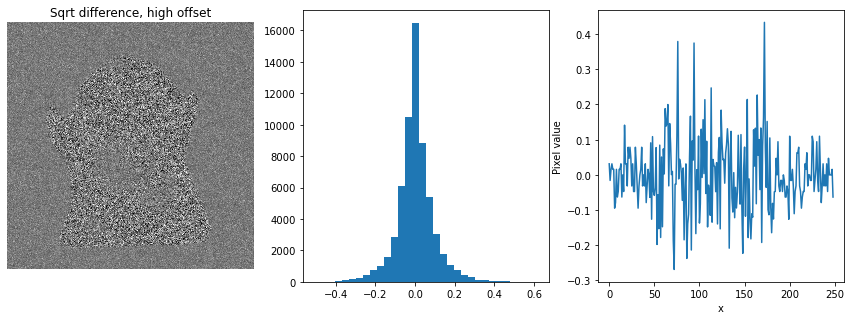

In [6]:
offset = 1000
im_clean_offset = im_clean + offset
im_noisy_offset = im_noisy + offset
show_image(np.sqrt(im_noisy_offset) - np.sqrt(im_clean_offset), title='Sqrt difference, high offset')

Uh-oh... with a high offset, the signal dependence of the noise seems to have returned.

Our square roots haven't helped, and have probably just confused matters.

### High gain

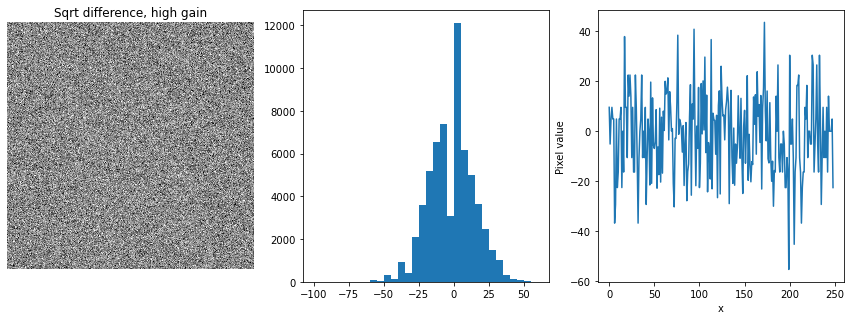

In [7]:
gain = 1000
im_clean_gain = im_clean * gain
im_noisy_gain = im_noisy * gain
show_image(np.sqrt(im_noisy_gain) - np.sqrt(im_clean_gain), title='Sqrt difference, high gain')

That looks fine - the square root transform has worked!

## Conclusion

Taking the square root of all pixel values is a handy trick to remove/reduce the signal-dependence of photon (Poisson) noise.

You *do* need to try to subtract any camera offset before applying it though.
You *don't* need to worry so much about any multiplicative gain factor.

This is most useful if you want to derive a global threshold based upon an estimate of the noise and apply it to the entire image.

For further noisy explorations, see https://petebankhead.gitbooks.io/imagej-intro/content/chapters/formation_noise/formation_noise.html

You can also try adjusting the `baseline` and `max_photons` values above to investigate other effects.